In [44]:
import pandas as pd
import numpy as np
import altair as alt

import pymc as pm
import bambi as bmb
import pymc_bart as pmb
import arviz as az

from pymc import do, observe

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('./data/discrimination.csv', index_col=0)

data.head()


gender  age ethnicity        party  conservative  discrimination
0    male   36  estonian  Keskerakond             1               0
1  female   50  estonian          SDE             0               0
2    male   67  estonian       Isamaa             1               0
3    male   58  estonian       Reform             0               0
4    male   62  estonian       Reform             1               0

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_conservative]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [discrimination]


Output()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_conservative'}>], dtype=object)

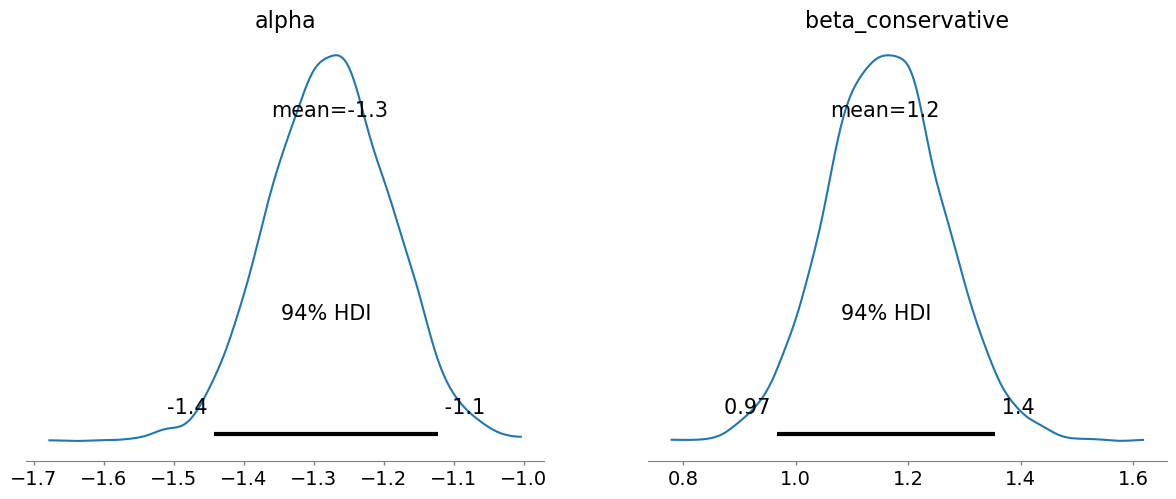

In [45]:
coords = {"predictors": ["conservative"]}

with pm.Model(coords=coords) as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_conservative = pm.Normal("beta_conservative", mu=0, sigma=10)
    
    p = pm.math.sigmoid(alpha + beta_conservative * data["conservative"])
    likelihood = pm.Bernoulli("discrimination", p=p, observed=data["discrimination"])
    
    trace = pm.sample()
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

pm.plot_posterior(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta\nconservative'}>,
        <Axes: title={'center': 'beta\nEKRE'}>,
        <Axes: title={'center': 'beta\nIsamaa'}>],
       [<Axes: title={'center': 'beta\nKeskerakond'}>,
        <Axes: title={'center': 'beta\nParempoolsed'}>,
        <Axes: title={'center': 'beta\nReform'}>,
        <Axes: title={'center': 'beta\nSDE'}>]], dtype=object)

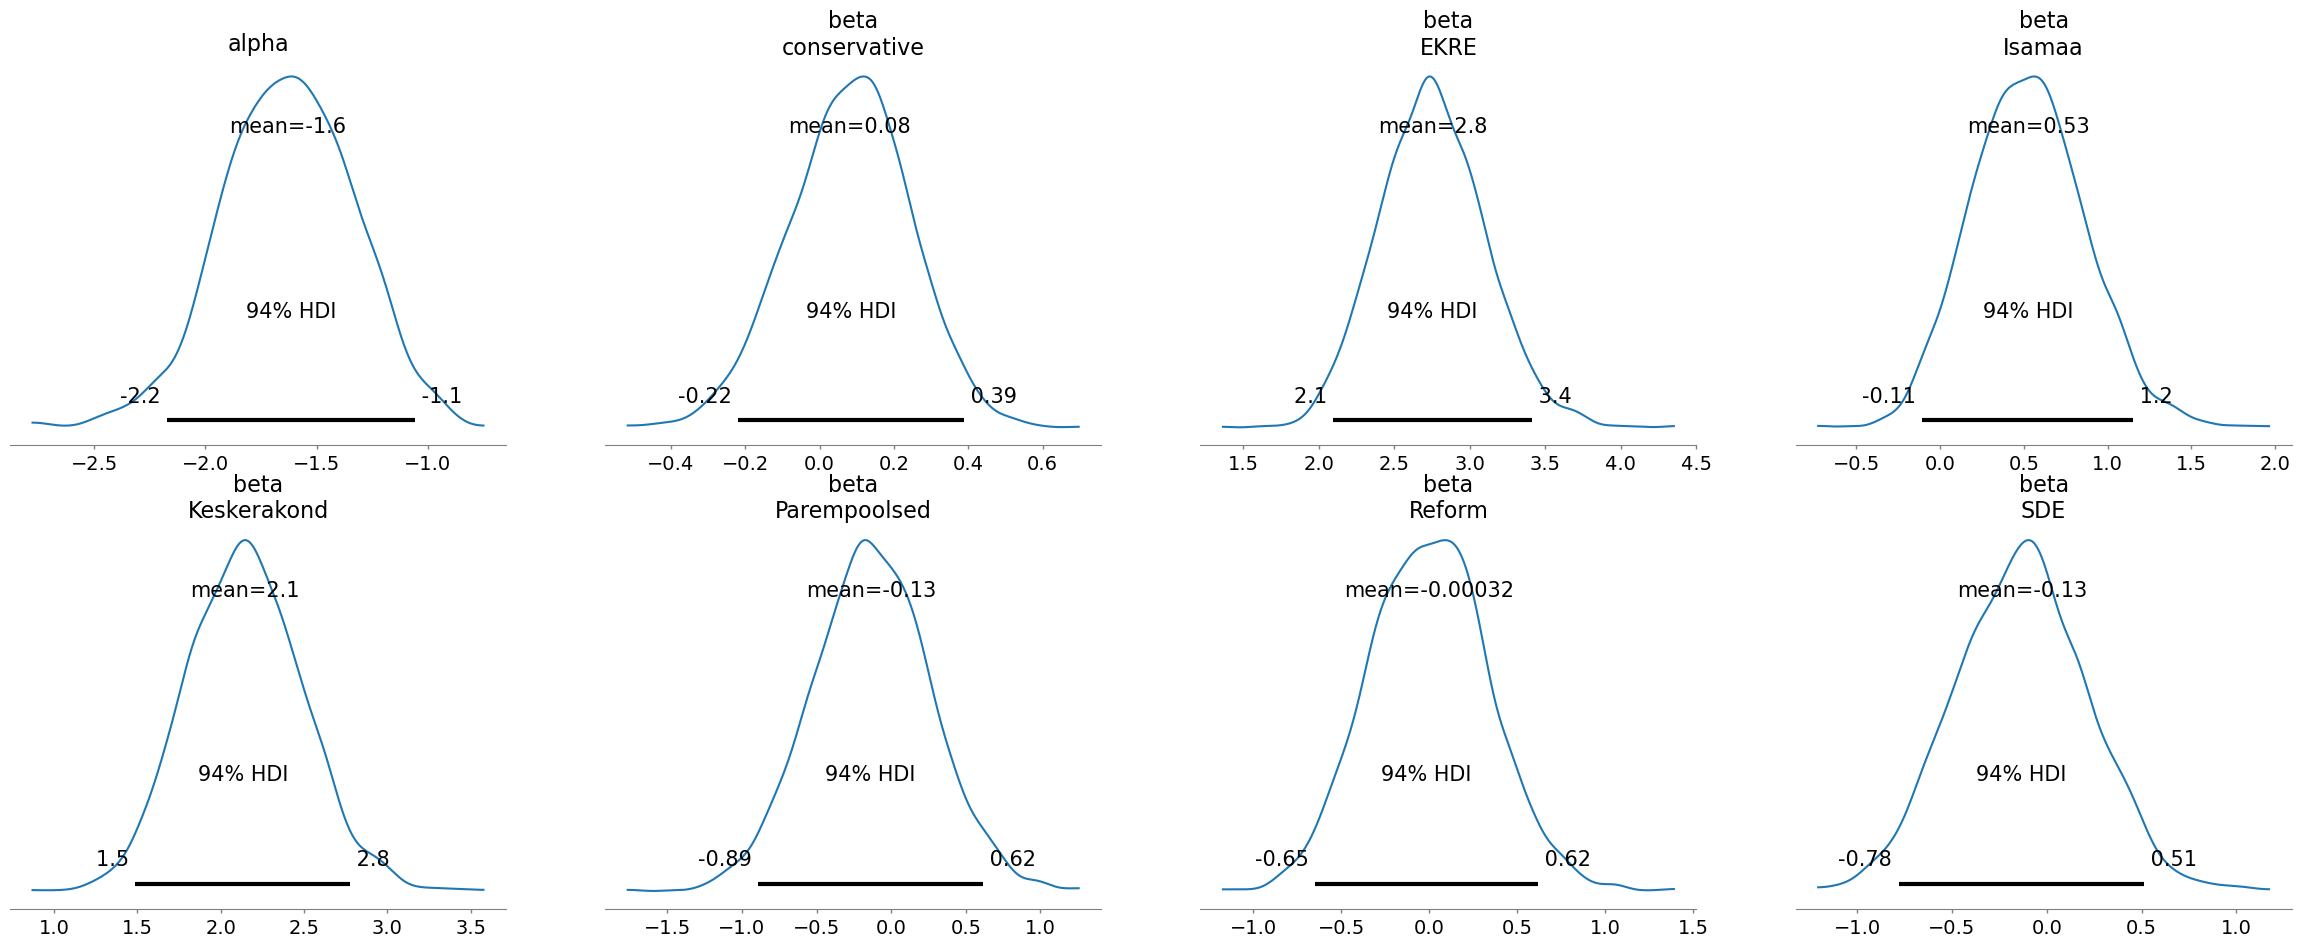

In [46]:

# Add party preference as dummy variables
party_dummies = pd.get_dummies(data["party"], drop_first=True).astype(int)
df = pd.concat([data, party_dummies], axis=1)

# Add dummies to predictors
coords["predictors"] = ["conservative"] + list(party_dummies.columns)

with pm.Model(coords=coords) as adjusted_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, dims="predictors")
    
    predictors = df[["conservative"] + list(party_dummies.columns)]
    p = pm.math.sigmoid(alpha + pm.math.dot(predictors, beta))
    likelihood = pm.Bernoulli("discrimination", p=p, observed=df["discrimination"])
    
    party_adjusted_trace = pm.sample()
    
pm.plot_posterior(party_adjusted_trace)

One simple trick we can use to take a lot of manual work out of defining simple PyMC models is to fit them with design matrices based on Wilkinson notation (this should be very familiar if you have used ``brms`` or ``lmer4`` in R or ``statsmodels``in Python). For this there are several options, here we use ``patsy``.

In [53]:
import patsy

# Create the design matrix using patsy
formula = "discrimination ~ 1 + conservative + C(party, Treatment) + age:gender"
y, X = patsy.dmatrices(formula, data=data, return_type='dataframe')

# Get the predictor names from the design matrix
predictor_names = X.columns.tolist()
coords = {"predictors": predictor_names}

with pm.Model(coords=coords) as patsy_model:
    # Priors
    beta = pm.Normal("beta", mu=0, sigma=2, dims="predictors")
    
    # Linear combination using dot product with design matrix X
    # Note: alpha is already included in the design matrix as the intercept
    linear_pred = pm.math.dot(X, beta)
    
    # Link function
    p = pm.math.sigmoid(linear_pred)
    
    # Likelihood
    likelihood = pm.Bernoulli("discrimination", p=p, observed=y.values.ravel())
    
    # Sample from the posterior
    party_adjusted_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

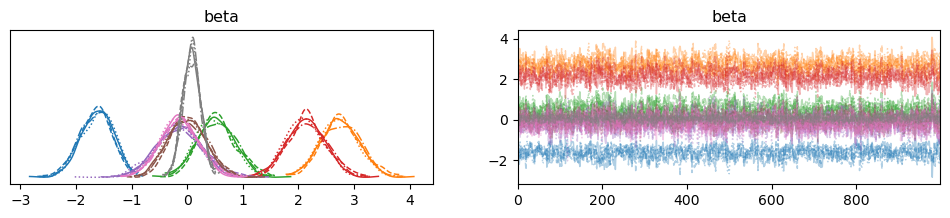

In [48]:
pm.plot_trace(party_adjusted_trace)

array([[<Axes: title={'center': 'beta\nIntercept'}>,
        <Axes: title={'center': 'beta\nC(party, Treatment)[T.EKRE]'}>,
        <Axes: title={'center': 'beta\nC(party, Treatment)[T.Isamaa]'}>,
        <Axes: title={'center': 'beta\nC(party, Treatment)[T.Keskerakond]'}>],
       [<Axes: title={'center': 'beta\nC(party, Treatment)[T.Parempoolsed]'}>,
        <Axes: title={'center': 'beta\nC(party, Treatment)[T.Reform]'}>,
        <Axes: title={'center': 'beta\nC(party, Treatment)[T.SDE]'}>,
        <Axes: title={'center': 'beta\nconservative'}>]], dtype=object)

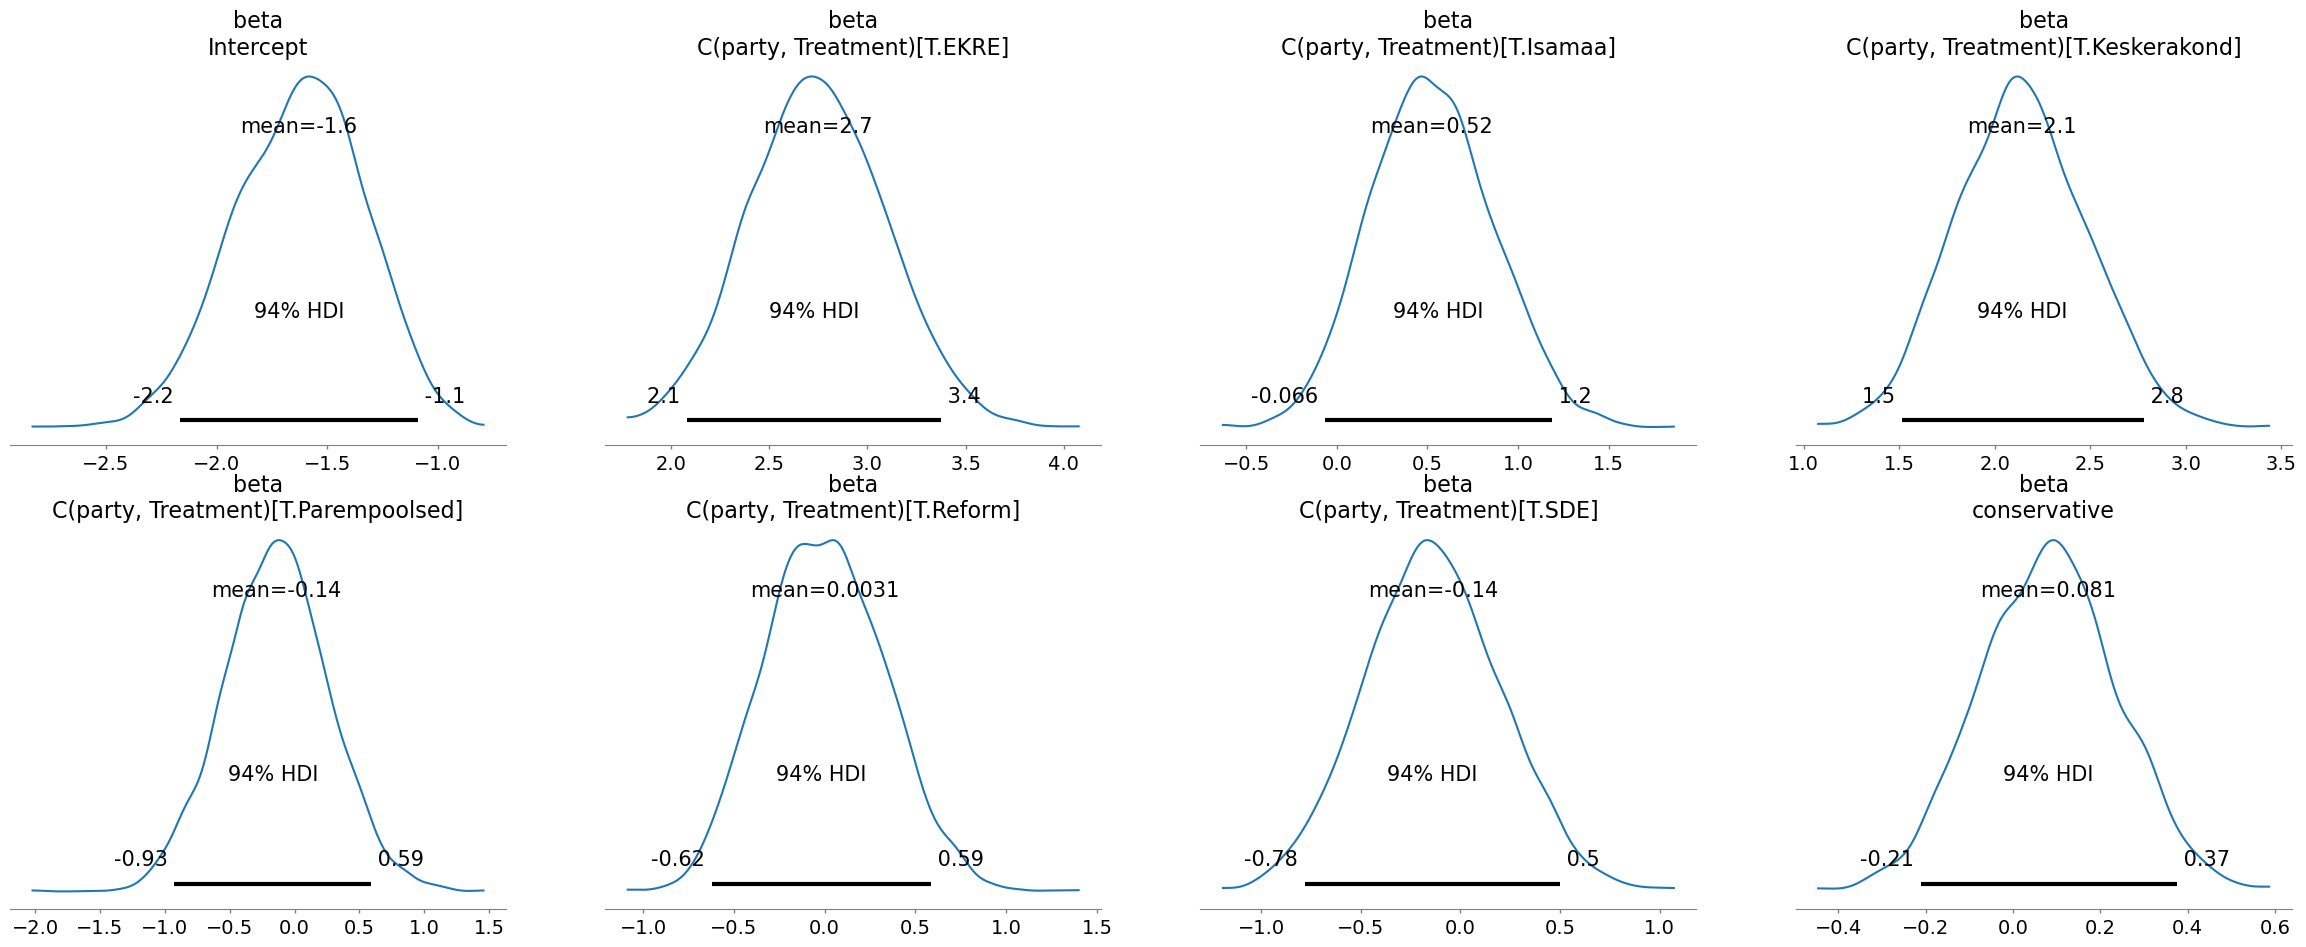

In [49]:
pm.plot_posterior(party_adjusted_trace)

In [69]:
party_model = bmb.Model(
    'party ~ conservative + gender + age + ethnicity + age:gender',
    df,
    family='categorical',
)

party_model

       Formula: party ~ conservative + gender + age + ethnicity + age:gender
        Family: categorical
          Link: p = softmax
  Observations: 2000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.4334)
            conservative ~ Normal(mu: 0.0, sigma: 5.1353)
            gender ~ Normal(mu: 0.0, sigma: 5.0006)
            age ~ Normal(mu: 0.0, sigma: 0.1797)
            ethnicity ~ Normal(mu: 0.0, sigma: 7.2931)
            age:gender ~ Normal(mu: 0.0, sigma: 0.0936)

In [72]:
dir(party_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_added_priors',
 '_build_priors',
 '_check_built',
 '_compute_likelihood_params',
 '_formula',
 '_set_family',
 '_set_priors',
 'auto_scale',
 'backend',
 'build',
 'built',
 'center_predictors',
 'components',
 'compute_log_likelihood',
 'constant_components',
 'data',
 'distributional_components',
 'dropna',
 'family',
 'fit',
 'formula',
 'graph',
 'noncentered',
 'plot_priors',
 'potentials',
 'predict',
 'prior_predictive',
 'response_component',
 'scaler',
 'set_alias',
 'set_priors']

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/pymc/sampling/mcmc.py:330: UserWarning: `idata_kwargs` are currently ignored by the nutpie sampler
  warnings.warn(
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/pymc/sampling/mcmc.py:335: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (14036), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'Intercept\nEKRE'}>,
        <Axes: title={'center': 'Intercept\nEKRE'}>],
       [<Axes: title={'center': 'Intercept\nIsamaa'}>,
        <Axes: title={'center': 'Intercept\nIsamaa'}>],
       [<Axes: title={'center': 'Intercept\nKeskerakond'}>,
        <Axes: title={'center': 'Intercept\nKeskerakond'}>],
       [<Axes: title={'center': 'Intercept\nParempoolsed'}>,
        <Axes: title={'center': 'Intercept\nParempoolsed'}>],
       [<Axes: title={'center': 'Intercept\nReform'}>,
        <Axes: title={'center': 'Intercept\nReform'}>],
       [<Axes: title={'center': 'Intercept\nSDE'}>,
        <Axes: title={'center': 'Intercept\nSDE'}>],
       [<Axes: title={'center': 'age\nEKRE'}>,
        <Axes: title={'center': 'age\nEKRE'}>],
       [<Axes: title={'center': 'age\nIsamaa'}>,
        <Axes: title={'center': 'age\nIsamaa'}>],
       [<Axes: title={'center': 'age\nKeskerakond'}>,
        <Axes: title={'center': 'age\nKeskerakond'}>],
       [<Axes: titl

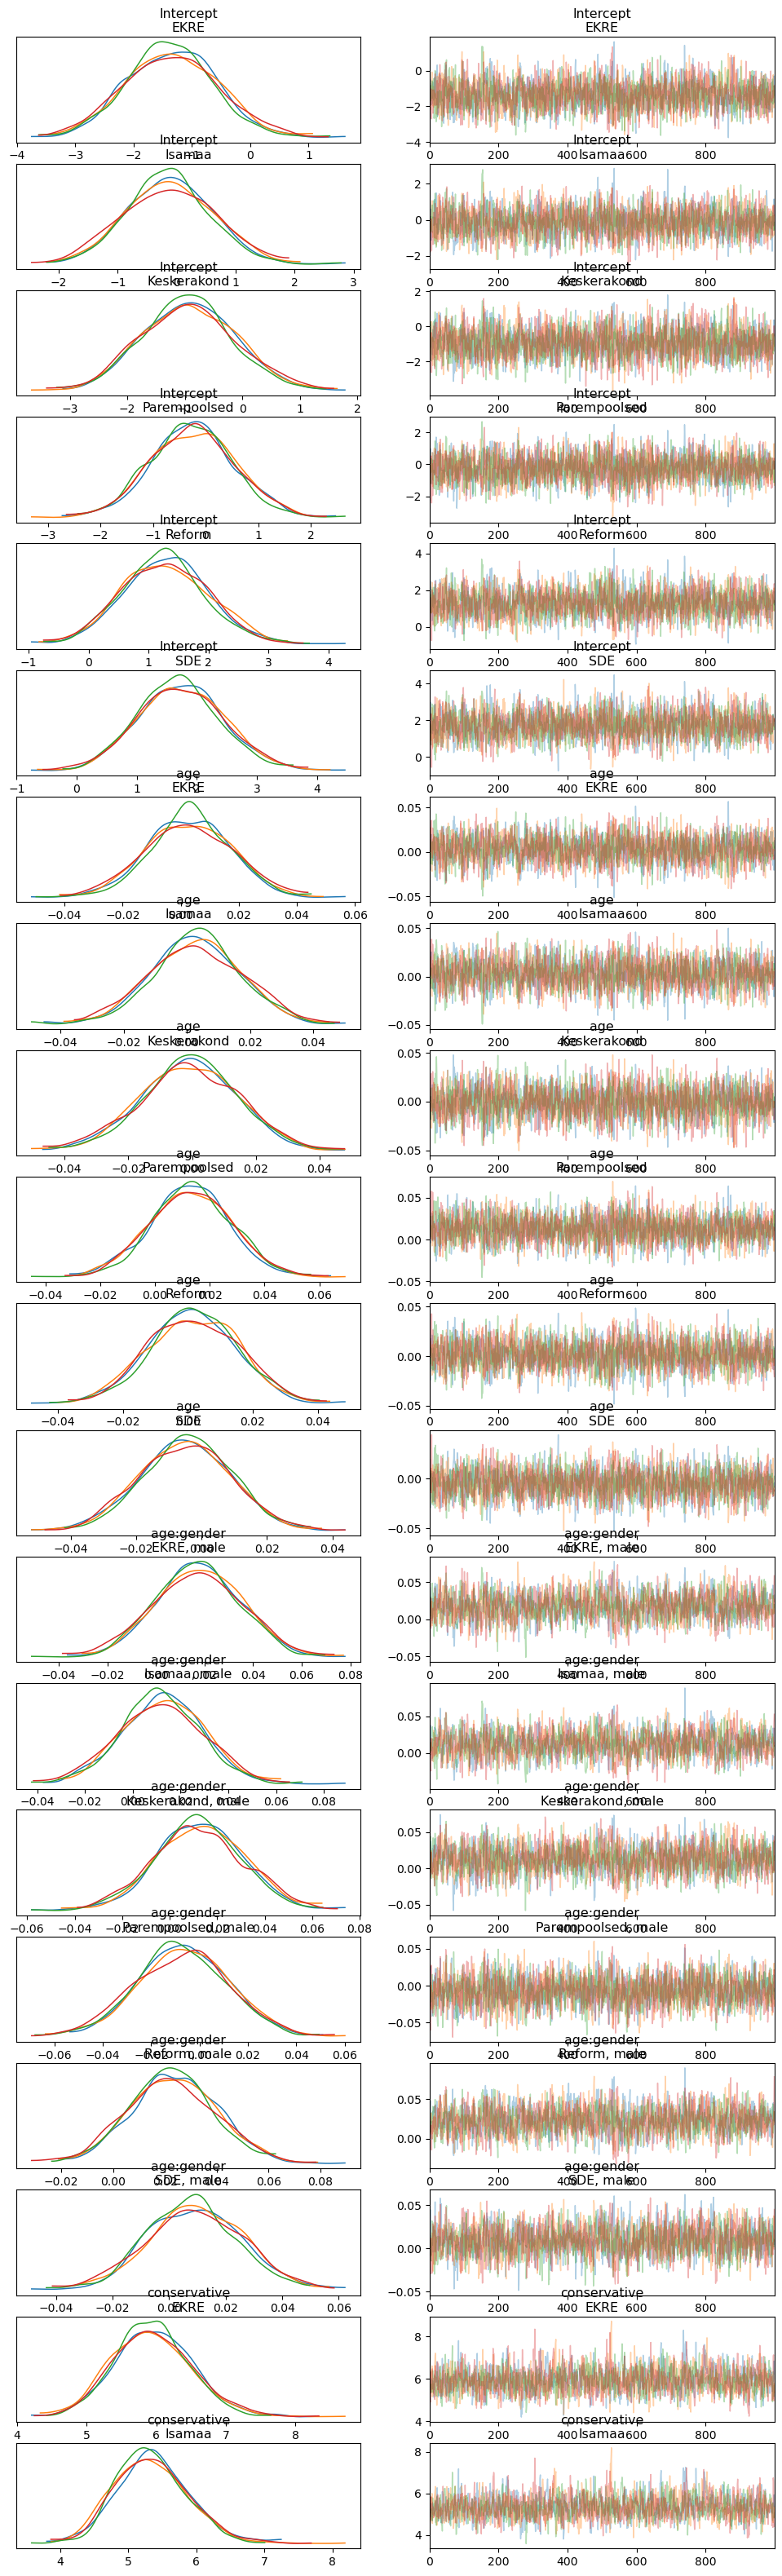

In [66]:
result = party_model.fit(idata_kwargs={"log_likelihood": True}, nuts_sampler='nutpie')

az.plot_trace(result, compact=False)

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (14036) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'Intercept\nEKRE'}>,
        <Axes: title={'center': 'Intercept\nIsamaa'}>,
        <Axes: title={'center': 'Intercept\nKeskerakond'}>,
        <Axes: title={'center': 'Intercept\nParempoolsed'}>],
       [<Axes: title={'center': 'Intercept\nReform'}>,
        <Axes: title={'center': 'Intercept\nSDE'}>,
        <Axes: title={'center': 'age\nEKRE'}>,
        <Axes: title={'center': 'age\nIsamaa'}>],
       [<Axes: title={'center': 'age\nKeskerakond'}>,
        <Axes: title={'center': 'age\nParempoolsed'}>,
        <Axes: title={'center': 'age\nReform'}>,
        <Axes: title={'center': 'age\nSDE'}>],
       [<Axes: title={'center': 'age:gender\nEKRE, male'}>,
        <Axes: title={'center': 'age:gender\nIsamaa, male'}>,
        <Axes: title={'center': 'age:gender\nKeskerakond, male'}>,
        <Axes: title={'center': 'age:gender\nParempoolsed, male'}>],
       [<Axes: title={'center': 'age:gender\nReform, male'}>,
        <Axes: title={'center': 'age:gend

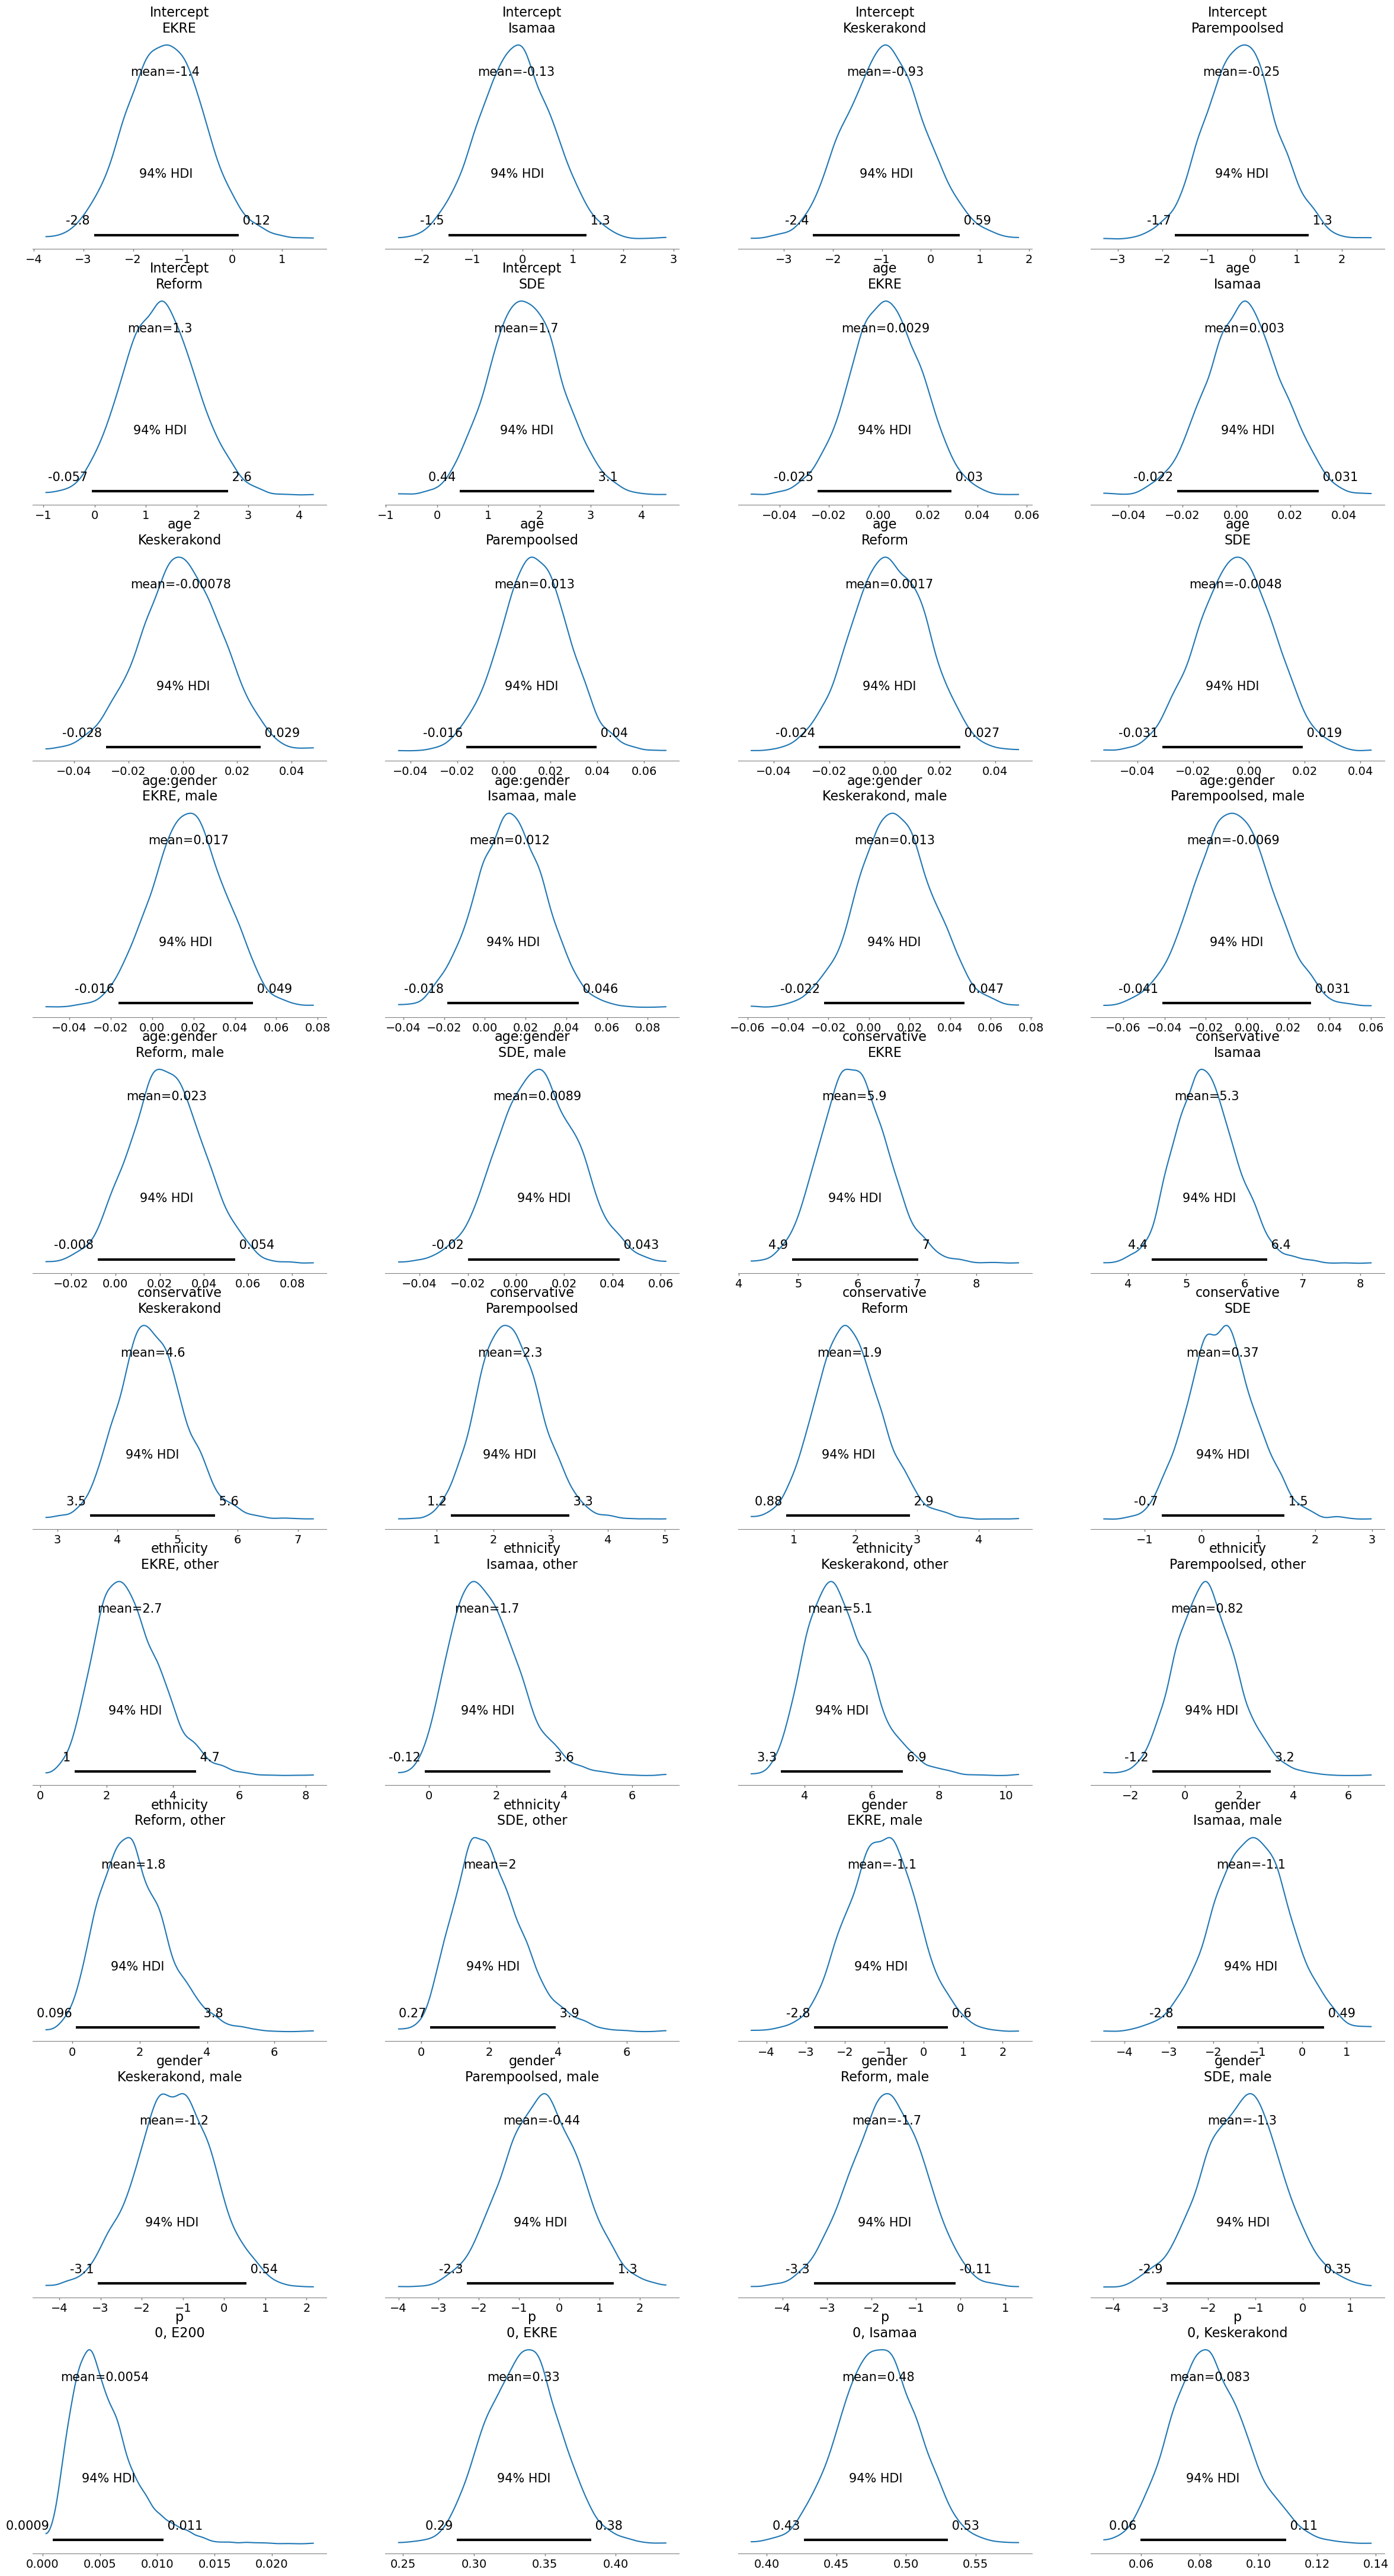

In [67]:
pm.plot_posterior(result)

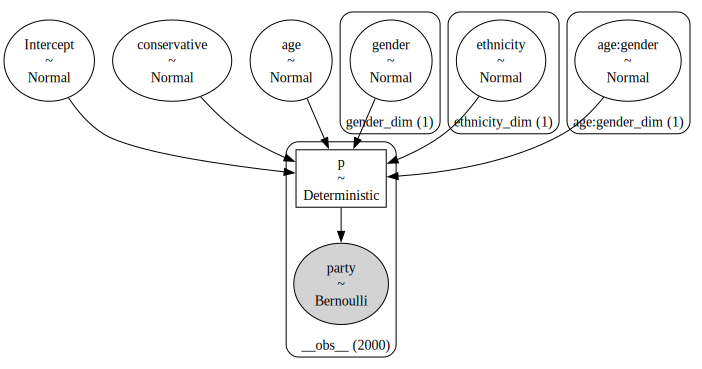

In [57]:
party_model.graph()

In [58]:
az.summary(result)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        -3.600  0.365  -4.277   -2.901      0.009    0.006    1827.0   
age               0.000  0.006  -0.011    0.012      0.000    0.000    1982.0   
age:gender[male]  0.006  0.008  -0.009    0.020      0.000    0.000    1749.0   
conservative      2.603  0.217   2.194    3.008      0.004    0.004    2545.0   
ethnicity[other] -0.423  0.179  -0.764   -0.096      0.004    0.003    2616.0   
gender[male]      0.085  0.397  -0.619    0.878      0.009    0.007    1801.0   

                  ess_tail  r_hat  
Intercept           1983.0    1.0  
age                 2434.0    1.0  
age:gender[male]    2243.0    1.0  
conservative        2154.0    1.0  
ethnicity[other]    2201.0    1.0  
gender[male]        2310.0    1.0

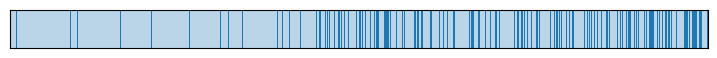

In [59]:
party_model.predict(result, kind="response")
ax = az.plot_separation(result, y="party", figsize=(9,0.5));


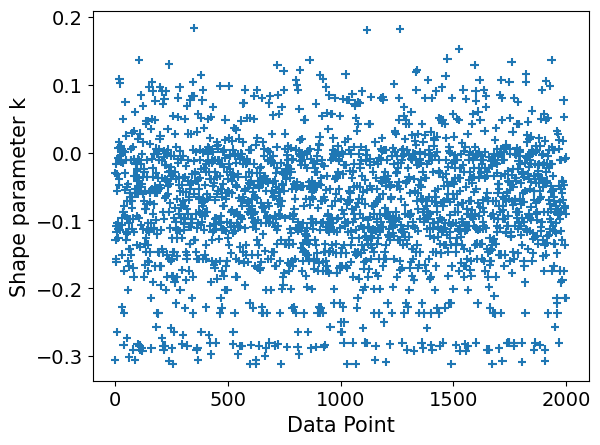

In [60]:
loo = az.loo(result, pointwise=True)
az.plot_khat(loo.pareto_k);


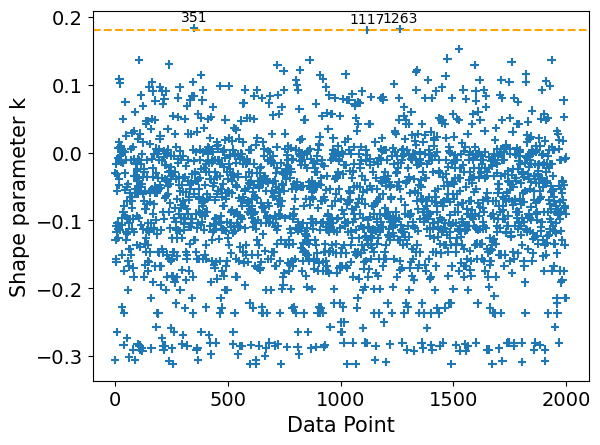

In [61]:
ax = az.plot_khat(loo.pareto_k)
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-3:].min()
ax.axhline(threshold, ls="--", color="orange")
influential_observations = df.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [62]:
df[loo.pareto_k.values >= threshold]

gender  age ethnicity party  conservative  discrimination  EKRE  Isamaa  \
351    male   52  estonian  EKRE             0               1     1       0   
1117   male   53  estonian  EKRE             0               1     1       0   
1263   male   47  estonian  EKRE             0               0     1       0   

      Keskerakond  Parempoolsed  Reform  SDE  
351             0             0       0    0  
1117            0             0       0    0  
1263            0             0       0    0

In [63]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 8),
    "conservative": np.repeat([0, 1], len(age) * 4),
    "ethnicity": np.tile(np.repeat(["estonian", "other"], len(age)), 4),
    "gender": np.tile(np.repeat(["male", "female"], len(age)), 4)
})
new_data

age  conservative ethnicity  gender
0     18             0  estonian    male
1     19             0  estonian    male
2     20             0  estonian    male
3     21             0  estonian    male
4     22             0  estonian    male
..   ...           ...       ...     ...
579   86             1     other  female
580   87             1     other  female
581   88             1     other  female
582   89             1     other  female
583   90             1     other  female

[584 rows x 4 columns]

In [64]:

party_model.predict(result, data=new_data)
vote_posterior = az.extract_dataset(result, num_samples=2000)["p"]

pd.concat([new_data, pd.DataFrame(vote_posterior.to_numpy().mean(axis=1))], axis=1).rename(columns={0: "p"})

alt.Chart(pd.concat([new_data, pd.DataFrame(vote_posterior.to_numpy().mean(axis=1))], axis=1).rename(columns={0: "p"})).mark_line().encode(
    x="age",
    y="mean(p)",
    color="gender"
).facet(
    "ethnicity:N"
)

alt.FacetChart(...)

In [96]:
party_model.build()
party_model.backend.model

## Drug use model

In [35]:
data = pd.read_csv('./data/drugs.csv', index_col='ID')

levels = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
use_dict = dict(zip(levels, range(len(levels))))

data.loc[:, 'Alcohol':'VSA'] = data.loc[:, 'Alcohol':'VSA'].replace(use_dict).infer_objects(copy=False).astype(int)

data.head()

Age Gender                          Education Country Ethnicity  Nscore  \
ID                                                                              
2   25-34      M                   Doctorate degree      UK     White      29   
3   35-44      M  Professional certificate/ diploma      UK     White      31   
4   18-24      F                     Masters degree      UK     White      34   
5   35-44      F                   Doctorate degree      UK     White      43   
6     65+      F            Left school at 18 years  Canada     White      29   

    Escore  Oscore  AScore  Cscore  ...  Ecstasy  Heroin Ketamine Legalh LSD  \
ID                                  ...                                        
2       52      55      48      41  ...        4       0        2      0   2   
3       45      40      32      34  ...        0       0        0      0   0   
4       34      46      47      46  ...        0       0        2      0   0   
5       28      43      41      50  ...        1       0        0      1   0   
6       38      35      55      52  ...        0       0        0      0   0   

   Meth Mushrooms Nicotine Semer VSA  
ID                                    
2     3         0        4     0   0  
3     0         1        0     0   0  
4     0         0        2     0   0  
5     0         2        2     0   0  
6     0         0        6     0   0  

[5 rows x 31 columns]

In [28]:
import pymc as pm

def scale_values(s):
    return (s - s.mean()) / s.std()

predictors = data.loc[:, 'Nscore':'SS'].apply(scale_values)
predictors['Gender'] = data.Gender.apply(lambda x: 1 if x=='M' else 0)
p_cols = predictors.columns

drug = 'Cannabis'
y = data[drug].apply(lambda x: 0 if x==0 else 1)

coords = {"predictors": list(p_cols)}

with pm.Model(coords=coords) as model:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='predictors')

    p = pm.math.sigmoid(alpha + pm.math.dot(predictors, beta))

    likelihood = pm.Bernoulli("drug_use", p=p, observed=y)

    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta\nNscore'}>,
        <Axes: title={'center': 'beta\nEscore'}>],
       [<Axes: title={'center': 'beta\nOscore'}>,
        <Axes: title={'center': 'beta\nAScore'}>,
        <Axes: title={'center': 'beta\nCscore'}>],
       [<Axes: title={'center': 'beta\nImpulsive'}>,
        <Axes: title={'center': 'beta\nSS'}>,
        <Axes: title={'center': 'beta\nGender'}>]], dtype=object)

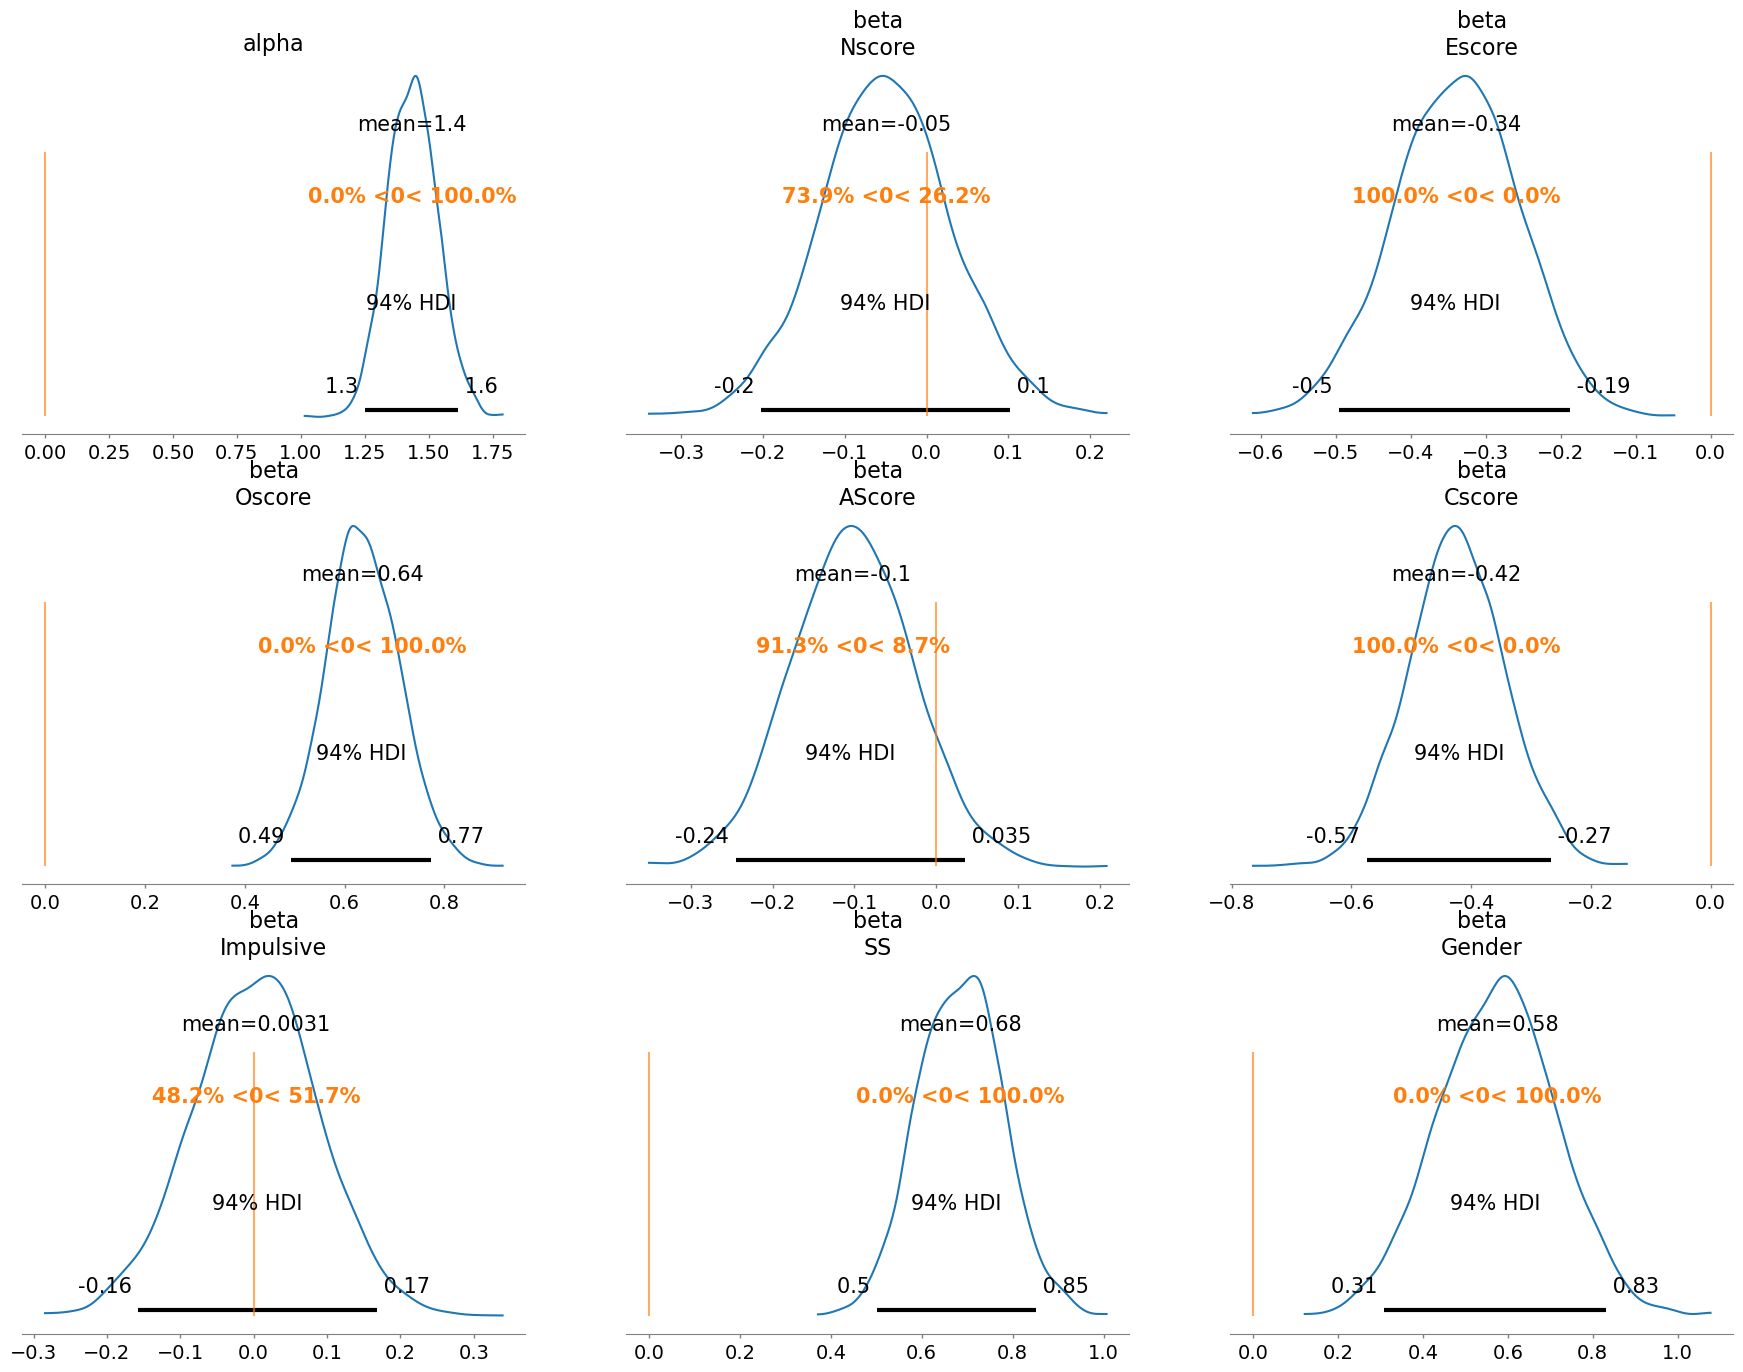

In [24]:
pm.plot_posterior(trace, var_names=["alpha", "beta"], coords=coords, ref_val=0)

In [42]:
drug = 'Ketamine'

drug_model = bmb.Model(
    f"{drug} ~ 'Nscore' + 'Escore' + 'Oscore' + 'AScore' + 'Cscore' + 'Impulsive' + 'SS'",
    data,
    family='categorical'
)

result = drug_model.fit()

az.summary(result)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Nscore, Escore, Oscore, AScore, Cscore, Impulsive, SS]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
AScore[1]    -0.074  0.024  -0.118   -0.028      0.000    0.000    8120.0   
AScore[2]    -0.030  0.015  -0.058   -0.003      0.000    0.000    6994.0   
AScore[3]    -0.010  0.015  -0.039    0.019      0.000    0.000    7305.0   
AScore[4]    -0.006  0.026  -0.053    0.044      0.000    0.000    7785.0   
AScore[5]    -0.080  0.028  -0.133   -0.029      0.000    0.000    8408.0   
AScore[6]    -0.006  0.085  -0.162    0.156      0.001    0.002    6669.0   
Cscore[1]     0.015  0.025  -0.037    0.058      0.000    0.000    6925.0   
Cscore[2]    -0.021  0.015  -0.050    0.006      0.000    0.000    8240.0   
Cscore[3]    -0.029  0.016  -0.059    0.001      0.000    0.000    7377.0   
Cscore[4]    -0.076  0.027  -0.125   -0.023      0.000    0.000    6970.0   
Cscore[5]    -0.044  0.028  -0.097    0.007      0.000    0.000    6309.0   
Cscore[6]    -0.100  0.079  -0.261    0.042      0.001    0.001    6796.0   
Escore[1]     0.010  0.027  -0.042    0.061      0.000    0.000    7350.0   
Escore[2]    -0.025  0.016  -0.054    0.005      0.000    0.000    5595.0   
Escore[3]     0.021  0.016  -0.011    0.051      0.000    0.000    6446.0   
Escore[4]     0.036  0.029  -0.015    0.091      0.000    0.000    7071.0   
Escore[5]    -0.057  0.029  -0.111   -0.002      0.000    0.000    6420.0   
Escore[6]    -0.061  0.086  -0.221    0.104      0.001    0.001    6032.0   
Impulsive[1] -0.078  0.215  -0.481    0.320      0.003    0.004    6703.0   
Impulsive[2]  0.047  0.123  -0.181    0.284      0.002    0.002    5660.0   
Impulsive[3]  0.039  0.130  -0.197    0.286      0.002    0.002    6627.0   
Impulsive[4] -0.122  0.215  -0.513    0.295      0.003    0.004    6849.0   
Impulsive[5]  0.007  0.242  -0.437    0.462      0.003    0.004    7054.0   
Impulsive[6] -0.380  0.671  -1.589    0.883      0.008    0.010    6328.0   
Intercept[1] -3.577  2.146  -7.653    0.383      0.025    0.032    7330.0   
Intercept[2] -1.552  1.235  -3.936    0.674      0.015    0.022    6742.0   
Intercept[3] -4.052  1.328  -6.776   -1.755      0.015    0.023    7504.0   
Intercept[4] -5.939  2.215 -10.254   -2.011      0.028    0.040    6245.0   
Intercept[5]  0.504  2.390  -3.989    4.945      0.030    0.039    6491.0   
Intercept[6] -4.196  7.087 -17.336    9.220      0.095    0.109    5801.0   
Nscore[1]     0.023  0.020  -0.013    0.061      0.000    0.000    7097.0   
Nscore[2]    -0.007  0.011  -0.029    0.014      0.000    0.000    7358.0   
Nscore[3]     0.013  0.012  -0.008    0.036      0.000    0.000    6824.0   
Nscore[4]     0.014  0.020  -0.023    0.051      0.000    0.000    6806.0   
Nscore[5]    -0.032  0.022  -0.073    0.008      0.000    0.000    6565.0   
Nscore[6]    -0.085  0.063  -0.198    0.037      0.001    0.001    6460.0   
Oscore[1]     0.025  0.026  -0.022    0.077      0.000    0.000    7029.0   
Oscore[2]     0.054  0.016   0.022    0.083      0.000    0.000    7190.0   
Oscore[3]     0.036  0.017   0.002    0.067      0.000    0.000    7786.0   
Oscore[4]     0.076  0.030   0.020    0.131      0.000    0.000    6634.0   
Oscore[5]     0.084  0.034   0.020    0.146      0.000    0.001    6476.0   
Oscore[6]     0.142  0.101  -0.039    0.337      0.001    0.002    5707.0   
SS[1]         0.505  0.221   0.063    0.891      0.003    0.004    7636.0   
SS[2]         0.441  0.134   0.195    0.695      0.002    0.002    5957.0   
SS[3]         0.675  0.138   0.398    0.908      0.002    0.002    6006.0   
SS[4]         0.371  0.232  -0.077    0.789      0.003    0.004    7428.0   
SS[5]         0.473  0.260  -0.003    0.953      0.003    0.005    6445.0   
SS[6]         0.375  0.725  -0.929    1.791      0.010    0.011    5681.0   

              ess_tail  r_hat  
AScore[1]       3244.0    1.0  
AScore[2]       2955.0    1.0  
AScore[3]       3137.0    1.0  
AScore[4]       3120.0    1.0  
AScore[5]       3157.0    1.0  
AScore[6]       3084.0    1.0  
Cscore[1]       2

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'AScore\n1'}>,
        <Axes: title={'center': 'AScore\n2'}>,
        <Axes: title={'center': 'AScore\n3'}>,
        <Axes: title={'center': 'AScore\n4'}>],
       [<Axes: title={'center': 'AScore\n5'}>,
        <Axes: title={'center': 'AScore\n6'}>,
        <Axes: title={'center': 'Cscore\n1'}>,
        <Axes: title={'center': 'Cscore\n2'}>],
       [<Axes: title={'center': 'Cscore\n3'}>,
        <Axes: title={'center': 'Cscore\n4'}>,
        <Axes: title={'center': 'Cscore\n5'}>,
        <Axes: title={'center': 'Cscore\n6'}>],
       [<Axes: title={'center': 'Escore\n1'}>,
        <Axes: title={'center': 'Escore\n2'}>,
        <Axes: title={'center': 'Escore\n3'}>,
        <Axes: title={'center': 'Escore\n4'}>],
       [<Axes: title={'center': 'Escore\n5'}>,
        <Axes: title={'center': 'Escore\n6'}>,
        <Axes: title={'center': 'Impulsive\n1'}>,
        <Axes: title={'center': 'Impulsive\n2'}>],
       [<Axes: title={'center': 'Impulsive\n3'}>,

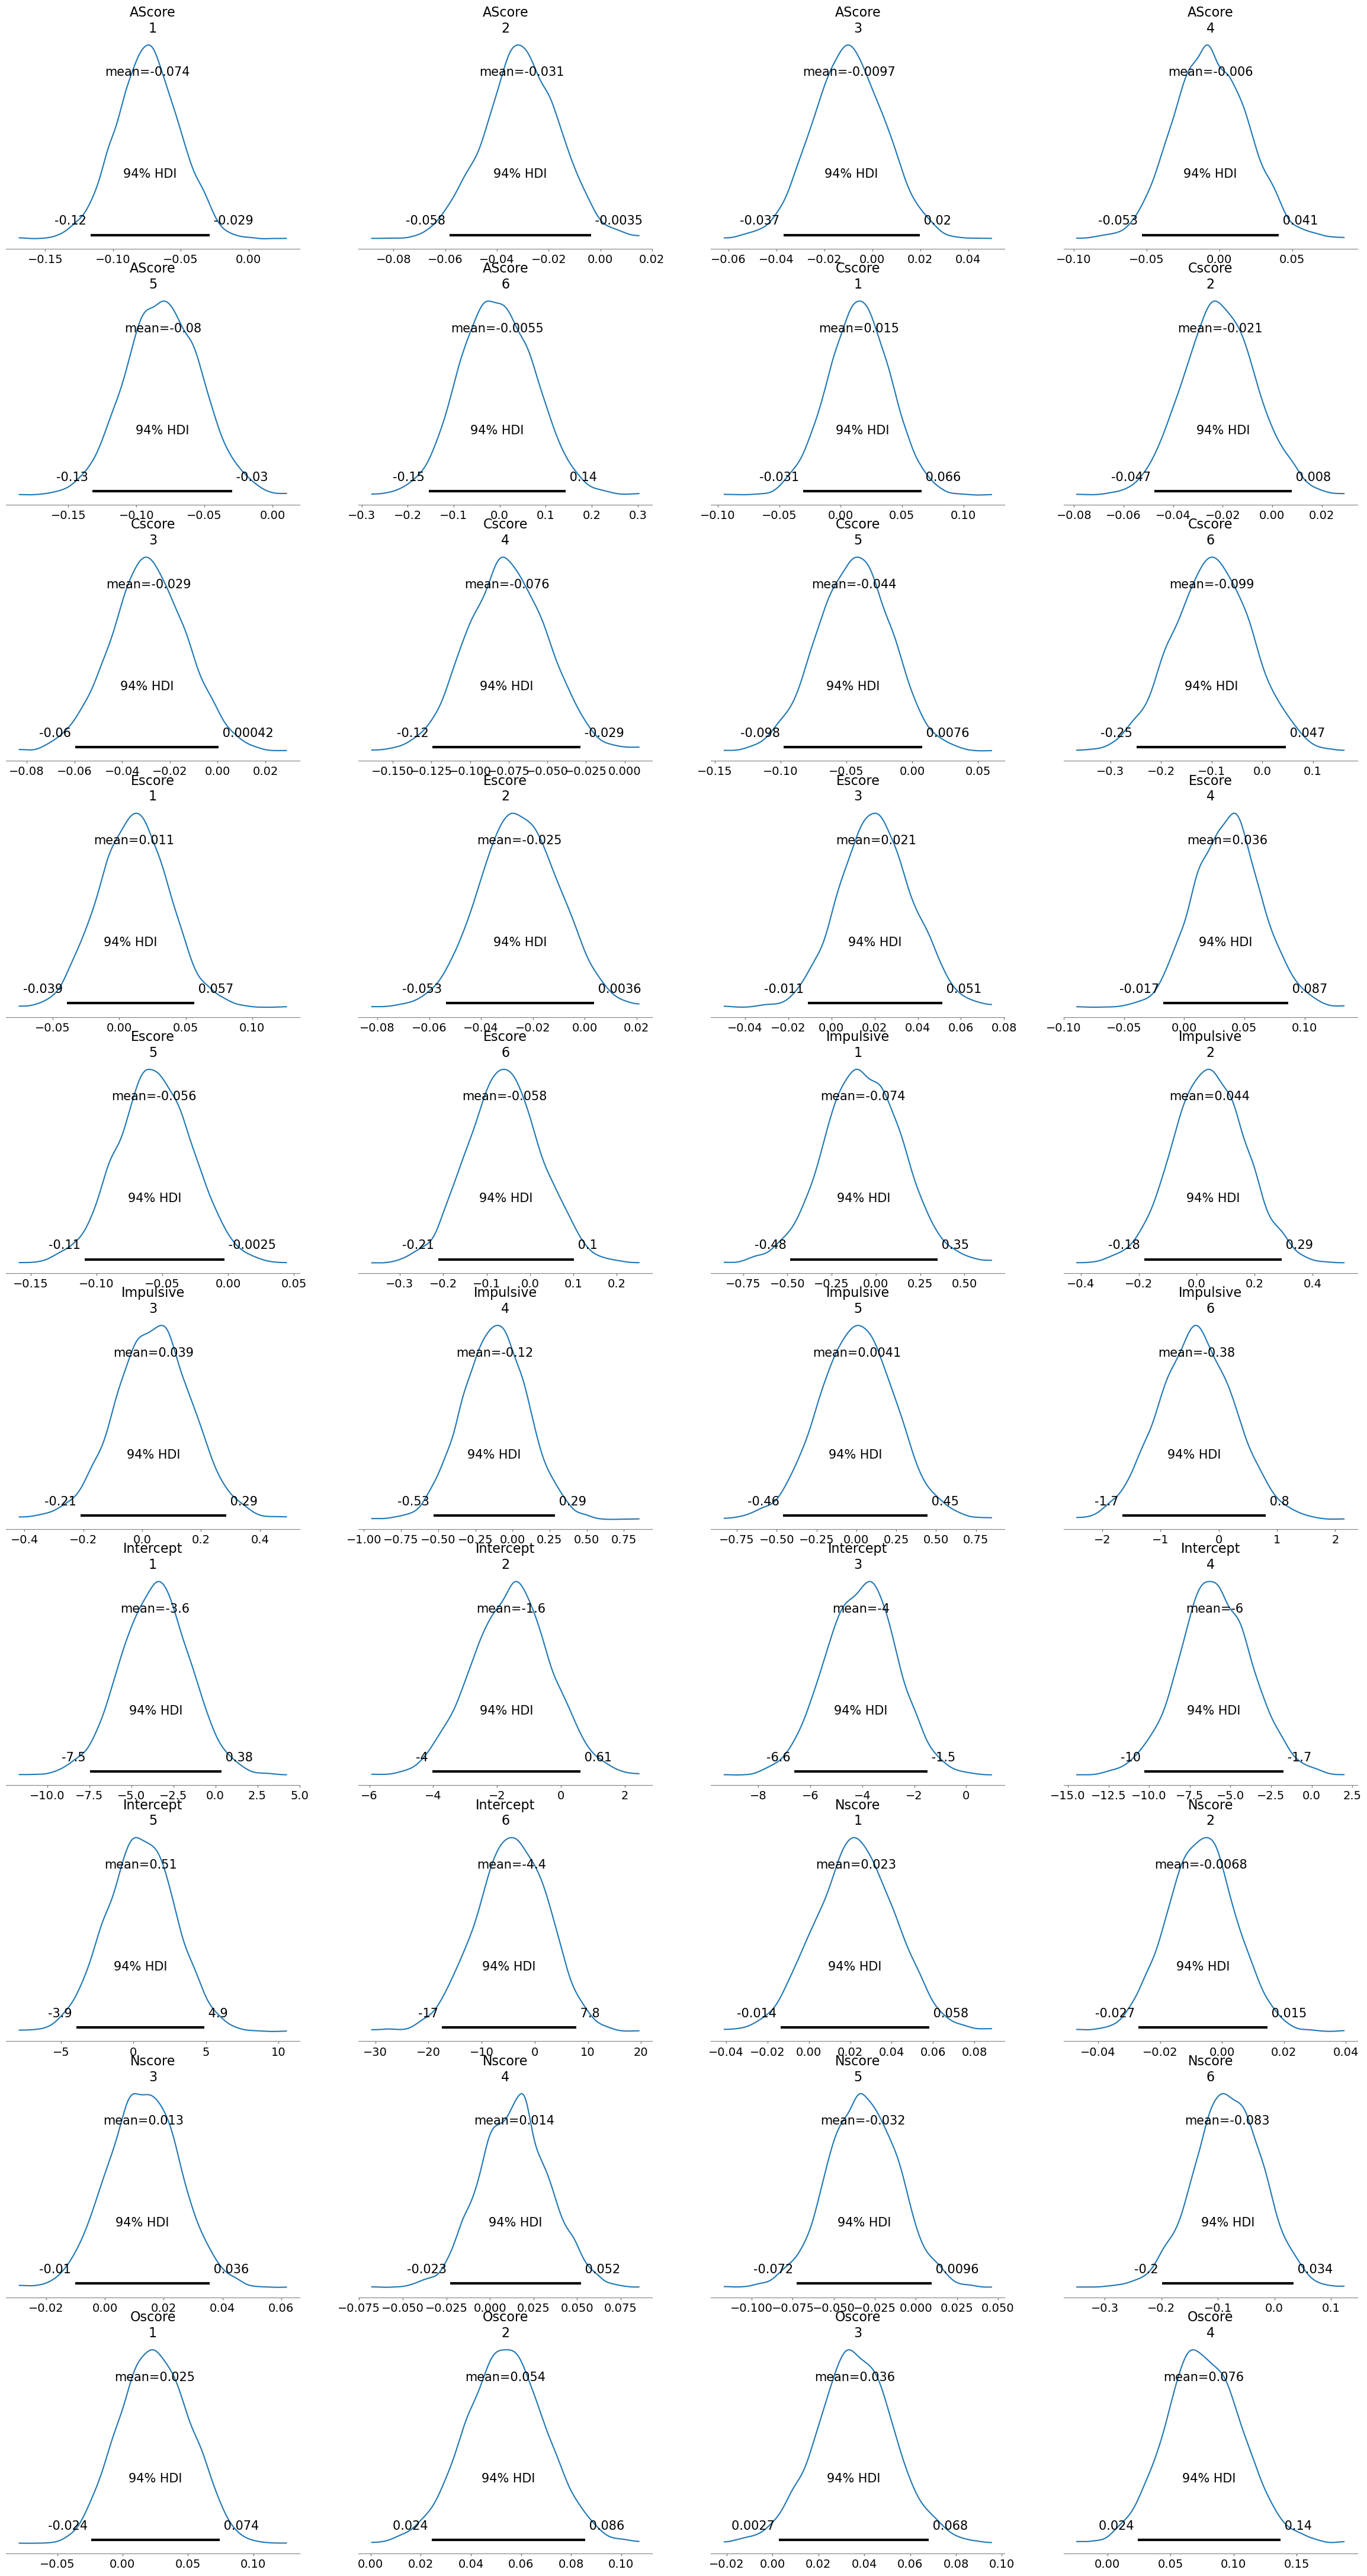

In [40]:
pm.plot_posterior(result)